In [1]:
import numpy as np
import matplotlib.pyplot as plt

Laplaces Equation:

$$\nabla^2 V=0$$

everywhere in the square. We are in 2D, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0$$

This equation can be discretely approximated as

$$\frac{V(x_{i+1}, y_j) - 2V(x_i, y_j) + V(x_{i-1}, y_j)}{(\Delta x)^2} + \frac{V(x_i, y_{j+1}) - 2V(x_i, y_j) + V(x_i, y_{j-1})}{(\Delta y)^2} = 0 $$

Noting that $ \Delta x = \Delta y$ in our array, we can solve for $V(x_i, y_j)$ yielding

$$V(x_i, y_j) = \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

So the idea is that if repeatedly set

$$V(x_i, y_j) \to \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$

$V$ will eventually converge to the true solution

### Problem 01: Solve the Laplace equation for fixed potential at the boundary 

In [2]:
# define the boundary conditions 
N = 100
edge = np.linspace(-1,1,N)
upper_y = np.cos(np.pi * edge/2)
lower_y = edge**4
upper_x = 1/(np.e**-1-np.e)*(np.exp(edge)-np.e)
lower_x = 0.5*(edge**2 -edge)

In [3]:
# define the mesh corrdinates 
xv,yv = np.meshgrid(edge,edge)

In [4]:
# define the potential matrix with boundary values (others are zero)
def set_init_potential():
    potential = np.zeros((N,N))
    potential[:,-1] = upper_x
    potential[:,0]  = lower_x
    potential[-1,:] = upper_y
    potential[0,:]  = lower_y
    return potential

In [5]:
# iteratively solve for the potential 
def cal_potential(potential,n_iter):
    length = len(potential[0])
    for n in range(n_iter):             # note that change the values not along the boundary 
        for j in range(1,length -1):
            for i in range(1,length -1):
                potential[i][j] = 1/4 * (potential[i+1][j] + potential[i-1][j] + potential[i][j+1]+potential[i][j-1])
    return potential

In [6]:
# set the boudary values first and compute the potential iteratively 
potential = set_init_potential()
potential = cal_potential(potential,1000)

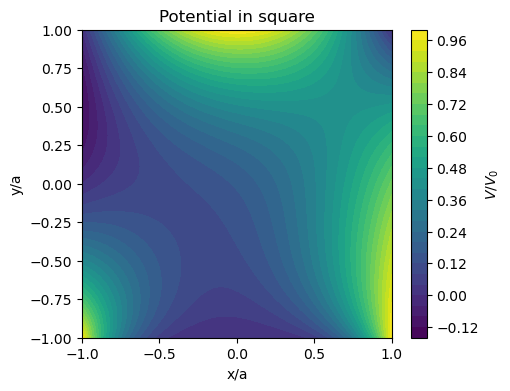

In [7]:
# plot the potential solution 
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

### Problem 02: Fixed potential at the boundary and constant potential at the middle 

In [8]:
# define the fixed potential box (and set it to 1)
def potential_block(x,y):
    return np.where((x>0.5)*(x<0.7)*(y>0.5)*(y<0.7),1,0)

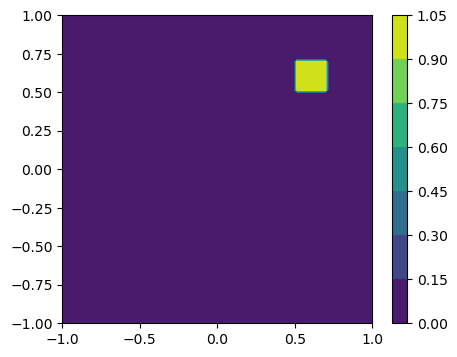

In [9]:
# plot the fixed potential 
plt.figure(figsize=(5,4))
plt.contourf(xv, yv, potential_block(xv,yv))
plt.colorbar()

In [10]:
# fixed potential 
fixed = potential_block(xv,yv)      # define fixed potential 
fixed_bool = fixed!=0               # fixed potential boolean mask

In [11]:
# solve for the potential for fixed pontial with boundary values 
def cal_potential(potential,fixed_bool,n_iter):
    length = len(potential[0])
    for n in range(n_iter):             # note here again we are not changing the potential along the boudary 
        for j in range(1,length -1):
            for i in range(1,length -1):
                if not fixed_bool[i][j]: # change the potential except the fixed values at the center 
                    potential[i][j] = 1/4 * (potential[i+1][j] + potential[i-1][j] + potential[i][j+1]+potential[i][j-1])
    return potential

In [13]:
# get the potential solution 
potential = set_init_potential()
potential[fixed_bool] = fixed[fixed_bool]
potential = cal_potential(potential,fixed_bool,1000)

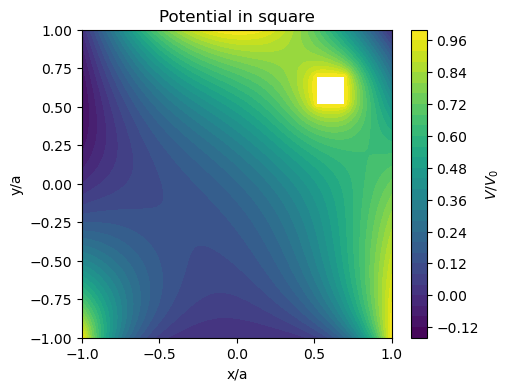

In [14]:
# plot the potential solution 
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

### Problem 03: Solve for the potential for a given geometry 

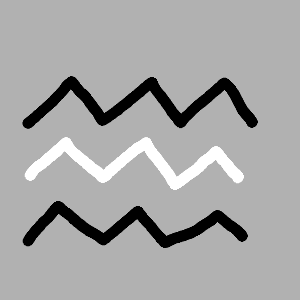

In [16]:
from PIL import Image,ImageOps
img = Image.open('images/accordion.png')
img = ImageOps.grayscale(img)
img

In [17]:
# convert image as np array 
img = np.asarray(img,dtype='int32')
img = img/255                       # normalize the image (pixel values)


In [18]:
# set the fixed potentials 
N,M = img.shape
potential = np.zeros((N,M))         # define initial potential array (which has the same shape as image) with zeros 
HV_bool = img<0.05                  
LV_bool = img>0.95
fixed_bool = HV_bool + LV_bool      # boolean mask for fixed potential 
fixed = img[fixed_bool]             # select the fixed potential values from image(HV =1 and LV =0)
potential[fixed_bool] = fixed       # set the fixed potential values 

In [19]:
# add the boundary values to potential 
edge = np.linspace(-1,1,N)
upper_y = np.cos(np.pi * edge / 2)
lower_y = edge**4
upper_x = 1/(np.e**-1 - np.e) * (np.exp(edge)-np.e)
lower_x = 0.5 * (edge**2-edge)

potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x

In [20]:
# use numba to make code faster(Note:loops in python is too slow)
from numba import jit
import numba
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def cal_potential(potential,fixed_bool,n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for j in range(1,length -1):
            for i in range(1,length -1):
                if not fixed_bool[i][j]:
                    potential[i][j] = 1/4 * (potential[i+1][j] + potential[i-1][j] + potential[i][j+1]+potential[i][j-1])
    return potential

In [21]:
# using numba 
potential = cal_potential(potential,fixed_bool,10000)

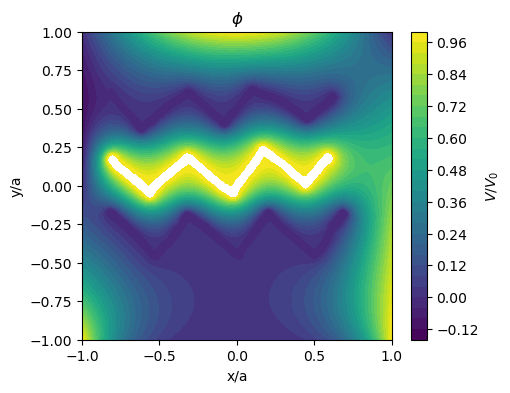

In [22]:
xv,yv = np.meshgrid(edge,edge)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('$\phi$')
plt.show()

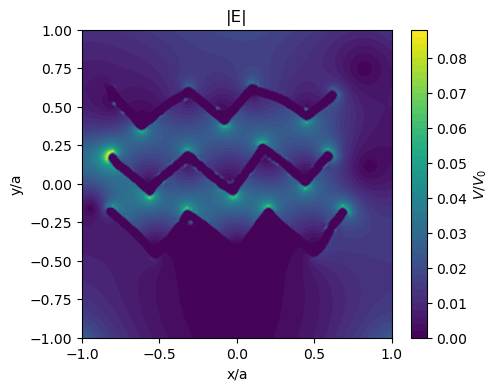

In [23]:
# get the electric field using the gradient of potential 
Ex, Ey = np.gradient(-potential)
E_mag = np.sqrt(Ex**2 + Ey**2)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, E_mag, 50)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('|E|')
plt.show()